In [19]:
# Gurobi for optimization
from gurobipy import GRB, Model, quicksum
import gurobipy as gp

# Pandas for data manipulation
import pandas as pd

# Numpy for numerical operations
import numpy as np

# Matplotlib for visualization
import matplotlib.pyplot as plt

# Datetime for handling time-related data
import datetime

# Pickle for saving/loading objects (optional, based on need)
import pickle


In [20]:
##SMALL DATASET 10 FLIGHTS 5 GATES

# # Seed for reproducibility
np.random.seed(46)

# Generate smaller flight data
flight_ids = [f"F{i:02d}" for i in range(1, 11)]
arrival_times = ['09:00', '08:30', '09:00', '08:30', '08:15',
                 '07:30', '10:15', '10:00', '10:25', '10:40']
departure_times = ['09:50', '09:10', '09:50', '10:20', '09:00',
                   '08:50', '11:20', '10:50', '11:55', '11:35']
passenger_numbers = [140, 138, 340, 293, 252,
                     105, 130, 166, 191, 178]
flight_types = ['Domestic', 'Domestic', 'International', 'International', 'International',
                'International', 'Domestic', 'Domestic', 'International', 'Domestic']

# Convert times to minutes since midnight for consistency with previous code
def time_to_minutes(t):
    h, m = map(int, t.split(':'))
    return h * 60 + m

arrival_times = [time_to_minutes(t) for t in arrival_times]
departure_times = [time_to_minutes(t) for t in departure_times]

flight_data = pd.DataFrame({
    'flight_id': flight_ids,
    'arrival_time': arrival_times,
    'departure_time': departure_times,
    'passenger_number': passenger_numbers,
    'flight_type': flight_types
})

# Generate smaller gate data
gate_ids = [f"Gate {i}" for i in range(1, 5)]
gate_types = ['Domestic', 'Domestic', 'International', 'International']

gate_data = pd.DataFrame({
    'gate_id': gate_ids,
    'gate_type': gate_types
})

# Calculate distances between gates (d_kl) and from gates to entrance/exit (ed_k)
distances = [
    [0, 2, 4, 6],
    [2, 0, 2, 4],
    [4, 2, 0, 2],
    [6, 4, 2, 0]
]

distance_df = pd.DataFrame(distances, index=gate_ids, columns=gate_ids)
ed_k = [5, 3, 3, 5]

# Store number of flights and gates
num_flights = len(flight_data)
num_gates = len(gate_data)

# Generate transiting passengers data (p_ij) with constraints
p_ij = np.zeros((num_flights, num_flights), dtype=int)

for i in range(num_flights):
    max_transit_passengers = passenger_numbers[i] // 2  # Maximum of 50% of the total passengers
    remaining_passengers = max_transit_passengers
    transfer_flights = np.random.choice([x for x in range(num_flights) if x != i], 1, replace=False)  # Choose 1 different flights
    for j in transfer_flights:
        if remaining_passengers > 0:
            p_ij[i, j] = np.random.randint(0, min(50, remaining_passengers + 1))
            remaining_passengers -= p_ij[i, j]

# Verify generated data
print("Flight Data:")
print(flight_data.head(num_flights))

print("\nGate Data:")
print(gate_data.head(num_gates))

print("\nDistance Matrix (d_kl):")
print(distance_df)

print("\nDistance to Entrance/Exit (ed_k):")
print(pd.Series(ed_k, index=gate_ids))

print("\nTransiting Passengers (p_ij):")
print(pd.DataFrame(p_ij, index=flight_ids, columns=flight_ids).head(num_flights))


Flight Data:
  flight_id  arrival_time  departure_time  passenger_number    flight_type
0       F01           540             590               140       Domestic
1       F02           510             550               138       Domestic
2       F03           540             590               340  International
3       F04           510             620               293  International
4       F05           495             540               252  International
5       F06           450             530               105  International
6       F07           615             680               130       Domestic
7       F08           600             650               166       Domestic
8       F09           625             715               191  International
9       F10           640             695               178       Domestic

Gate Data:
  gate_id      gate_type
0  Gate 1       Domestic
1  Gate 2       Domestic
2  Gate 3  International
3  Gate 4  International

Distance Matrix (d_kl):


### Assingment Based on this model

- **Flights assigned to gate**:
    - Flight F01 is assigned to Gate 1
    - Flight F02 is assigned to Gate 2
    - Flight F03 is assigned to Gate 3
    - Flight F04 is assigned to Gate 4
    - Flight F05 is assigned to Gate 3
    - Flight F06 is assigned to Apron
    - Flight F07 is assigned to Apron
    - Flight F08 is assigned to Gate 1
    - Flight F09 is assigned to Gate 3
    - Flight F10 is assigned to Gate 2

### Model Explanation

The objective of the FC formulation is to minimize the total walking distance of passengers at the airport, considering both transfer passengers and non-transfer passengers. The model includes the following key components:

- **Parameters**:
  - `num_flights`: Number of flights
  - `num_gates`: Number of gates
  - `arrival_times`: Arrival times of flights
  - `departure_times`: Departure times of flights
  - `passenger_numbers`: Number of passengers per flight
  - `flight_types`: Type of flight (domestic/international)
  - `gate_types`: Type of gate (domestic/international)
  - `distances`: Distance matrix between gates

- **Decision Variables**:
  - `x[i, k]`: Binary variable, 1 if flight \(i\) is assigned to gate \(k\), 0 otherwise
  - `w[i, k, l]`: Continuous variable representing the number of passengers from flight \(i\) through gate \(k\) to gate \(l\)

- **Objective Function**:
  - Minimize the total walking distance of passengers.

- **Constraints**:
  - Each flight must be assigned to exactly one gate.
  - Gates cannot be double-booked.
  - Flow balance constraints for transfer passengers.


In [21]:
# Initialize the Gurobi model
model = Model("FC_Formulation")

# Distance penalty for the apron
apron_distance_penalty = 30

# Distance matrices
d_kl = np.zeros((num_gates + 1, num_gates + 1))
d_kl[:num_gates, :num_gates] = distance_df.values
d_kl[num_gates, :] = apron_distance_penalty  # Distance from apron to all gates
d_kl[:, num_gates] = apron_distance_penalty  # Distance from all gates to apron
d_kl[num_gates, num_gates] = apron_distance_penalty  # Distance from apron to itself

# Distance to/from exit for each gate (including apron)
ed_k = np.append(ed_k, apron_distance_penalty)  # Append apron distance to exit

print(d_kl,ed_k)
# Passengers data
e_i = flight_data['passenger_number'].values - np.sum(p_ij, axis=1)
f_i = flight_data['passenger_number'].values - np.sum(p_ij, axis=0)

# Aircraft type (domestic/international)
g_i = flight_data['flight_type'].apply(lambda x: 'D' if x == 'Domestic' else 'I').values

# Sets of domestic and international gates
K_D = [k for k, t in zip(range(num_gates), gate_types) if t == 'Domestic']
K_I = [k for k, t in zip(range(num_gates), gate_types) if t == 'International']
K_D.append(num_gates)  # Add apron to domestic gates
K_I.append(num_gates)  # Add apron to international gates

# Number of gates
m = num_gates

# Generating overlap sets for all time steps
def generate_overlap_sets(flight_data):
    # Initialize dictionaries to hold overlap sets
    I_Dt = []
    I_It = []
    T_D = {}
    T_I = {}
    
    # Iterate through each minute of the day
    for t in range(1440):
        domestic_overlaps = set()
        international_overlaps = set()
        
        # Check for overlapping flights at time t
        for i, flight in flight_data.iterrows():
            if flight['arrival_time'] <= t < flight['departure_time']:
                if flight['flight_type'] == 'Domestic':
                    domestic_overlaps.add(flight['flight_id'])
                else:
                    international_overlaps.add(flight['flight_id'])
        
        if domestic_overlaps:
            I_Dt.append(domestic_overlaps)
        if international_overlaps:
            I_It.append(international_overlaps)
    
    # Convert I_Dt and I_It to T_D and T_I
    for idx, overlap_set in enumerate(I_Dt):
        if overlap_set:
            T_D[f"TD{idx+1}"] = overlap_set
            
    for idx, overlap_set in enumerate(I_It):
        if overlap_set:
            T_I[f"TI{idx+1}"] = overlap_set
    
    return T_D, T_I

# Generate overlap sets
T_D, T_I = generate_overlap_sets(flight_data)

# Print overlap sets
print("Overlap Sets for Domestic Flights (T_D):")
for key, value in T_D.items():
    print(f"{key}: {value}")

print("\nOverlap Sets for International Flights (T_I):")
for key, value in T_I.items():
    print(f"{key}: {value}")

# Calculate N_A_star
def calculate_N_A_star(T_D, T_I, K_D, K_I):
    N_A_star = 0
    for overlap_set in T_D.values():
        if len(overlap_set) > len(K_D):
            N_A_star += len(overlap_set) - len(K_D) + 1
            print(f"Domestic Overlap Set: {overlap_set}, Excess: {len(overlap_set) - len(K_D)+1}")
    for overlap_set in T_I.values():
        if len(overlap_set) > len(K_I):
            N_A_star += len(overlap_set) - len(K_I) + 1
            print(f"International Overlap Set: {overlap_set}, Excess: {len(overlap_set) - len(K_I)+1}")
    return N_A_star

N_A_star = calculate_N_A_star(T_D, T_I, K_D, K_I)
print("\nN_A_star:", N_A_star)

# Define function to calculate NA*
def calculate_NA_star(flight_data, num_gates):
    # Create a list to hold the number of aircraft at each minute
    time_slots = [0] * 1440  # There are 1440 minutes in a day

    # Populate the list with the number of overlapping aircraft at each minute
    for index, flight in flight_data.iterrows():
        for t in range(flight['arrival_time'], flight['departure_time']):
            time_slots[t] += 1
    
    # Calculate the maximum number of aircraft exceeding the available gates
    max_excess_aircraft = max([max(0, count - num_gates) for count in time_slots])
    
    return max_excess_aircraft

NA_star = calculate_NA_star(flight_data, num_gates)
print("NA*:", NA_star)

# Decision Variables
x = model.addVars(num_flights, num_gates + 1, vtype=GRB.BINARY, name="x")
w = model.addVars(num_flights, num_gates + 1, num_gates + 1, vtype=GRB.CONTINUOUS, name="w")

# Verify variables
print("Decision variables defined.")


[[ 0.  2.  4.  6. 30.]
 [ 2.  0.  2.  4. 30.]
 [ 4.  2.  0.  2. 30.]
 [ 6.  4.  2.  0. 30.]
 [30. 30. 30. 30. 30.]] [ 5  3  3  5 30]
Overlap Sets for Domestic Flights (T_D):
TD1: {'F02'}
TD2: {'F02'}
TD3: {'F02'}
TD4: {'F02'}
TD5: {'F02'}
TD6: {'F02'}
TD7: {'F02'}
TD8: {'F02'}
TD9: {'F02'}
TD10: {'F02'}
TD11: {'F02'}
TD12: {'F02'}
TD13: {'F02'}
TD14: {'F02'}
TD15: {'F02'}
TD16: {'F02'}
TD17: {'F02'}
TD18: {'F02'}
TD19: {'F02'}
TD20: {'F02'}
TD21: {'F02'}
TD22: {'F02'}
TD23: {'F02'}
TD24: {'F02'}
TD25: {'F02'}
TD26: {'F02'}
TD27: {'F02'}
TD28: {'F02'}
TD29: {'F02'}
TD30: {'F02'}
TD31: {'F01', 'F02'}
TD32: {'F01', 'F02'}
TD33: {'F01', 'F02'}
TD34: {'F01', 'F02'}
TD35: {'F01', 'F02'}
TD36: {'F01', 'F02'}
TD37: {'F01', 'F02'}
TD38: {'F01', 'F02'}
TD39: {'F01', 'F02'}
TD40: {'F01', 'F02'}
TD41: {'F01'}
TD42: {'F01'}
TD43: {'F01'}
TD44: {'F01'}
TD45: {'F01'}
TD46: {'F01'}
TD47: {'F01'}
TD48: {'F01'}
TD49: {'F01'}
TD50: {'F01'}
TD51: {'F01'}
TD52: {'F01'}
TD53: {'F01'}
TD54: {'F01'}
TD55: {'F

In [22]:
# Objective function components\n",
objective = quicksum(d_kl[k, l] * w[i, k, l] for i in range(num_flights) for k in range(num_gates + 1) for l in range(num_gates + 1)) + \
            quicksum((e_i[i] + f_i[i]) * ed_k[k] * x[i, k] for i in range(num_flights) for k in range(num_gates + 1))

model.setObjective(objective, GRB.MINIMIZE)

# Verify objective
print("Objective function defined.")

Objective function defined.


In [23]:
# Constraint 3: Assign each aircraft to exactly one gate
for i in range(num_flights):
    if g_i[i] == 'D':
        model.addConstr(quicksum(x[i, k] for k in K_D) == 1, name=f"Assign_Domestic_{i}")
    else:
        model.addConstr(quicksum(x[i, k] for k in K_I) == 1, name=f"Assign_International_{i}")

# Add Constraints (4) and (5): At most one aircraft can be assigned to a fixed gate during a certain time interval
# Constraint (4) for domestic flights (excluding apron)
for t, I_Dt in T_D.items():
    for k in K_D[:-1]:  # Exclude the apron
        model.addConstr(quicksum(x[flight_ids.index(flight), k] for flight in I_Dt) <= 1, name=f"MaxOneAircraft_Domestic_{t}_Gate{k}")

# Constraint (5) for international flights (excluding apron)
for t, I_It in T_I.items():
    for k in K_I[:-1]:  # Exclude the apron
        model.addConstr(quicksum(x[flight_ids.index(flight), k] for flight in I_It) <= 1, name=f"MaxOneAircraft_International_{t}_Gate{k}")

# # Constraint 6: Minimum apron assignments
# model.addConstr(quicksum(x[i, num_gates] for i in range(num_flights)) <= 2, name="min_apron_assignments")

# Constraint (10): Passenger flow balance constraints (outbound)
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I  # Select the appropriate gate set
    for k in gate_set:
        model.addConstr(
            quicksum(w[i, k, l] for l in range(num_gates + 1)) == x[i, k] * sum(p_ij[i, j] for j in range(num_flights)),
            name=f"FlowBalance_{i}_{k}"
        )

# Constraint 11: Passenger flow balance constraints (inbound)
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I  # Select the appropriate gate set
    for k in range(num_gates + 1):  # Iterate over all gates including the apron
        model.addConstr(
            quicksum(w[i, l, k] for l in gate_set) == 
            quicksum(p_ij[i, j] * x[j, k] for j in range(num_flights)),
            name=f"PassengerFlow_{i}_{k}"
        )

# Constraint 12: Non-negativity of flow variables
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I  # Select the appropriate gate set
    for k in gate_set:
        for l in range(num_gates + 1):  # Iterate over all gates including the apron
            model.addConstr(
                w[i, k, l] >= 0,
                name=f"NonNegativeFlow_{i}_{k}_{l}"
            )

# Constraint (13): Ensure that overlapping domestic aircraft are assigned to the apron
for t, I_Dt in T_D.items():
    if len(I_Dt) > len(K_D) - 1:  # K_D includes the apron, so len(K_D) - 1 is the number of fixed gates
        model.addConstr(
            quicksum(x[flight_ids.index(flight), num_gates] for flight in I_Dt) >= len(I_Dt) - (len(K_D) - 1),
            name=f"ApronAssignment_Domestic_{t}"
        )

# Constraint (14): Ensure that overlapping international aircraft are assigned to the apron
for t, I_It in T_I.items():
    if len(I_It) > len(K_I) - 1:  # K_I includes the apron, so len(K_I) - 1 is the number of fixed gates
        model.addConstr(
            quicksum(x[flight_ids.index(flight), num_gates] for flight in I_It) >= len(I_It) - (len(K_I) - 1),
            name=f"ApronAssignment_International_{t}"
        )

# Verify constraints
print("Constraints defined.")


Constraints defined.


In [24]:
# Optimize model
model.optimize()

flight_assignments = {}
# Print results
if model.status == GRB.OPTIMAL:
    # Print flight assignments to gates
    for i in range(num_flights):
        for k in range(num_gates + 1):
            if x[i, k].X > 0.5:  # Check if the flight is assigned to the gate
                flight_assignments[f"F{i+1:02d}"] = k + 1  # Store gate number (1-indexed)
                gate = 'Apron' if k == num_gates else gate_ids[k]
                print(f"Flight {flight_data.loc[i, 'flight_id']} is assigned to {gate}")
    
    # Print the flow of passengers between gates and to the exit
    print("\nPassenger Flow Between Gates and to the Exit:")
    for i in range(num_flights):
        for k in range(num_gates + 1):
            gate_from = 'Apron' if k == num_gates else gate_ids[k]
            total_transfer_passengers = 0
            # Flow to other gates
            for l in range(num_gates + 1):
                if w[i, k, l].X > 0:  # Only print non-zero flows
                    gate_to = 'Apron' if l == num_gates else gate_ids[l]
                    print(f"Flow from Flight {flight_data.loc[i, 'flight_id']} at {gate_from} to {gate_to}: {w[i, k, l].X}")
                    total_transfer_passengers += w[i, k, l].X
            # Flow to exit
            if x[i, k].X > 0.5:
                passengers_to_exit = flight_data.loc[i, 'passenger_number'] - total_transfer_passengers
                if passengers_to_exit > 0:
                    print(f"Flow from Flight {flight_data.loc[i, 'flight_id']} at {gate_from} to Exit: {passengers_to_exit}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1140 rows, 300 columns and 1912 nonzeros
Model fingerprint: 0xbf7adca8
Variable types: 250 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [2e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 69678.000000
Presolve removed 1057 rows and 137 columns
Presolve time: 0.00s
Presolved: 83 rows, 163 columns, 375 nonzeros
Variable types: 129 continuous, 34 integer (34 binary)
Found heuristic solution: objective 64008.000000

Root relaxation: objective 2.580500e+04, 22 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1140 rows, 300 columns and 1912 nonzeros
Model fingerprint: 0xbf7adca8
Variable types: 250 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [2e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolved: 83 rows, 163 columns, 375 nonzeros

Continuing optimization...


Explored 1 nodes (22 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 25805 64008 69678 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.580500000000e+04, best bound 2.580500000000e+04, gap 0.0000%


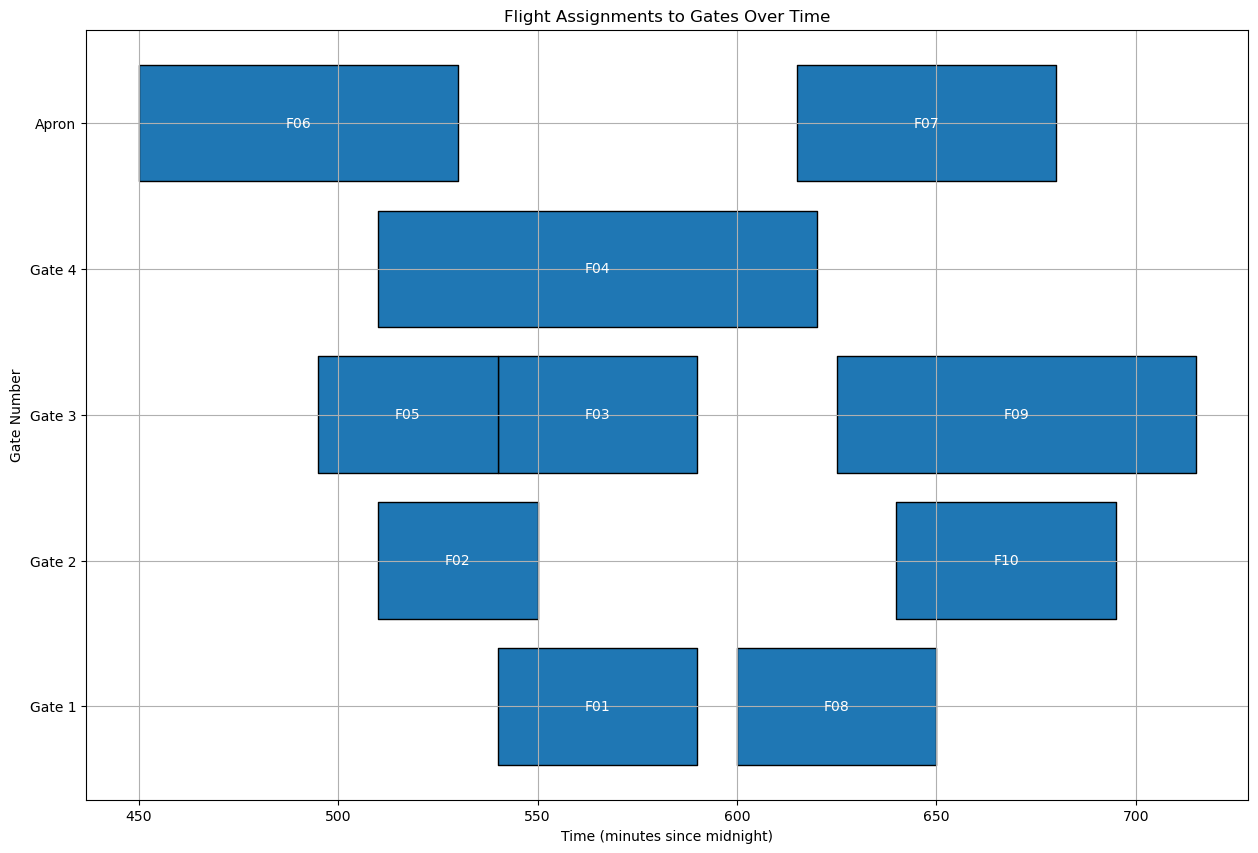

In [25]:
# Optimize model
model.optimize()

# Create a dictionary to store flight assignments
flight_assignments_img = {}

# Collect flight assignments to gates
if model.status == GRB.OPTIMAL:
    for i in range(num_flights):
        for k in range(num_gates + 1):
            if x[i, k].X > 0.5:  # Check if the flight is assigned to the gate
                gate = 'Apron' if k == num_gates else gate_ids[k]
                flight_assignments_img[flight_data.loc[i, 'flight_id']] = {
                    'gate': gate,
                    'arrival_time': flight_data.loc[i, 'arrival_time'],
                    'departure_time': flight_data.loc[i, 'departure_time']
                }
    
    # Plot the flight assignments
    fig, ax = plt.subplots(figsize=(15, 10))

    for flight_id, info in flight_assignments_img.items():
        gate = info['gate']
        arrival_time = info['arrival_time']
        departure_time = info['departure_time']
        gate_num = gate_ids.index(gate) + 1 if gate != 'Apron' else num_gates + 1

        ax.broken_barh([(arrival_time, departure_time - arrival_time)], (gate_num - 0.4, 0.8),
                       facecolors=('tab:blue'), edgecolors=('black'))
        ax.text((arrival_time + departure_time) / 2, gate_num, flight_id,
                ha='center', va='center', color='white')

    # Set labels and title
    ax.set_xlabel('Time (minutes since midnight)')
    ax.set_ylabel('Gate Number')
    ax.set_title('Flight Assignments to Gates Over Time')
    ax.set_yticks(range(1, num_gates + 2))
    ax.set_yticklabels(gate_ids + ['Apron'])
    ax.grid(True)

    plt.show()
else:
    print("No optimal solution found.")


## Verification of the model ##

In [26]:
# Optimize the model
model.optimize()

# Print results and verify constraints
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found. Verifying constraints...")

    constraints_met = True

    # Verifying Constraint 3: Each flight is assigned to exactly one gate
    all_flights_assigned_correctly = True
    for i in range(num_flights):
        gate_count = sum(x[i, k].X > 0.5 for k in range(num_gates + 1))
        if gate_count != 1:
            print(f"Constraint 3 violation: Flight {flight_data.loc[i, 'flight_id']} is assigned to {gate_count} gates.")
            all_flights_assigned_correctly = False
            constraints_met = False

    if all_flights_assigned_correctly:
        print("\nConstraint 3 is met: All flights are correctly assigned to exactly one gate or the apron.")

    # Verifying Constraint 4 for domestic flights
    domestic_violations = []
    for t, I_Dt in T_D.items():
        for k in K_D[:-1]:  # Exclude the apron
            assigned_flights = sum(x[flight_ids.index(flight), k].X > 0.5 for flight in I_Dt)
            if assigned_flights > 1:
                domestic_violations.append((t, k, assigned_flights))
                print(f"Constraint 4 violation: Time {t}, Gate {k} - {assigned_flights} domestic flights assigned.")
                constraints_met = False

    # Verifying Constraint 5 for international flights
    international_violations = []
    for t, I_It in T_I.items():
        for k in K_I[:-1]:  # Exclude the apron
            assigned_flights = sum(x[flight_ids.index(flight), k].X > 0.5 for flight in I_It)
            if assigned_flights > 1:
                international_violations.append((t, k, assigned_flights))
                print(f"Constraint 5 violation: Time {t}, Gate {k} - {assigned_flights} international flights assigned.")
                constraints_met = False

    if not domestic_violations and not international_violations:
        print("Constraints 4 and 5 are met: All gate assignments during time intervals are correct.")

    # Verifying Constraint 10 for outbound passenger flows
    outbound_violations = []
    for i in range(num_flights):
        gate_set = K_D if flight_data.loc[i, 'flight_type'] == 'Domestic' else K_I  # Adjusted to use flight_data
        for k in gate_set:
            expected_flow = sum(p_ij[i][j] for j in range(num_flights)) * x[i, k].X
            actual_flow = sum(w[i, k, l].X for l in range(num_gates + 1))
            if abs(actual_flow - expected_flow) > 1e-5:  # Allowing a small numerical tolerance
                outbound_violations.append((i, k, actual_flow, expected_flow))
                print(f"Constraint 10 violation: Outbound flow mismatch for Flight {flight_data.loc[i, 'flight_id']} at Gate {k}: Expected {expected_flow}, Actual {actual_flow}")
                constraints_met = False

    if not outbound_violations:
        print("Constraint 10 is met: Outbound passenger flows are correct.")

    # Verify Constraint 11 for inbound passenger flows
    inbound_violations = []
    for i in range(num_flights):
        gate_set = K_D if g_i[i] == 'D' else K_I
        for k in range(num_gates + 1):
            total_flow = sum(w[i, l, k].X for l in gate_set)
            expected_flow = sum(p_ij[i, j] * x[j, k].X for j in range(num_flights))
            if abs(total_flow - expected_flow) > 1e-5:  # Allowing a small numerical tolerance
                inbound_violations.append((i, k, total_flow, expected_flow))
                print(f"Constraint 11 violation: Inbound flow mismatch for Flight {flight_ids[i]} at Gate {k}: Expected {expected_flow}, Actual {total_flow}")
                constraints_met = False

    if not inbound_violations:
        print("Constraint 11 is met: Inbound passenger flows are correct.")

    # Verify Constraint 12: Non-negativity of flow variables
    non_negative = True
    for i in range(num_flights):
        gate_set = K_D if g_i[i] == 'D' else K_I
        for k in gate_set:
            for l in range(num_gates + 1):
                if w[i, k, l].X < 0:
                    print(f"Constraint 12 violation: Flight {flight_ids[i]}, Gate {k} to Gate {l}, Negative flow: {w[i, k, l].X}")
                    non_negative = False
                    constraints_met = False

    if non_negative:
        print("Constraint 12 is met: All flow variables are non-negative.")

    # Verify Constraint 13 for domestic flights
    domestic_constraint_13_met = True
    for t, I_Dt in T_D.items():
        if len(I_Dt) > len(K_D) - 1:
            apron_count = sum(x[flight_ids.index(flight), num_gates].X > 0.5 for flight in I_Dt)
            required_apron_count = len(I_Dt) - (len(K_D) - 1)
            if apron_count < required_apron_count:
                print(f"Constraint 13 violation: Time Interval {t}: {apron_count} domestic flights assigned to apron, required: {required_apron_count}")
                domestic_constraint_13_met = False
                constraints_met = False

    if domestic_constraint_13_met:
        print("Constraint 13 is met: Domestic flights assigned to apron correctly.")

    # Verify Constraint 14 for international flights
        international_constraint_14_met = True
    for t, I_It in T_I.items():
        if len(I_It) > len(K_I) - 1:
            apron_count = sum(x[flight_ids.index(flight), num_gates].X > 0.5 for flight in I_It)
            required_apron_count = len(I_It) - (len(K_I) - 1)
            if apron_count < required_apron_count:
                print(f"Constraint 14 violation: Time Interval {t}: {apron_count} international flights assigned to apron, required: {required_apron_count}")
                international_constraint_14_met = False
                constraints_met = False

    if international_constraint_14_met:
        print("Constraint 14 is met: International flights assigned to apron correctly.")

    if constraints_met:
        print("\nAll constraints are met.")

    # Detailed Passenger Flow Report
    print("\nDetailed Passenger Flow Report:")
    for i in range(num_flights):
        flight_id = flight_data.loc[i, 'flight_id']
        print(f"\nFlight {flight_id} Passenger Flows:")
        for k in range(num_gates + 1):
            gate_from = 'Apron' if k == num_gates else gate_ids[k]
            if x[i, k].X > 0.5:
                print(f"  Assigned to {gate_from}")
                total_transfer_passengers = 0
                for l in range(num_gates + 1):
                    if w[i, k, l].X > 0:
                        gate_to = 'Apron' if l == num_gates else gate_ids[l]
                        flow = w[i, k, l].X
                        total_transfer_passengers += flow
                        print(f"    -> {flow} passengers to {gate_to}")
                passengers_to_exit = flight_data.loc[i, 'passenger_number'] - total_transfer_passengers
                if passengers_to_exit > 0:
                    print(f"    -> {passengers_to_exit} passengers to Exit")

    # Print the inbound passenger flow between gates
    print("\nInbound Passenger Flow Between Gates:\n")
    for k in range(num_gates + 1):
        gate_to = 'Apron' if k == num_gates else gate_ids[k]
        total_inbound_passengers = 0
        for i in range(num_flights):
            for l in range(num_gates + 1):
                if w[i, l, k].X > 0:  # Only print non-zero flows
                    gate_from = 'Apron' if l == num_gates else gate_ids[l]
                    print(f"Flow from Flight {flight_data.loc[i, 'flight_id']} at {gate_to} from {gate_from}: {w[i, l, k].X}")
                    total_inbound_passengers += w[i, l, k].X
        print(f"Total inbound passengers to {gate_to}: {total_inbound_passengers}\n")

else:
    print("No optimal solution found or there are issues with the model.")



Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1140 rows, 300 columns and 1912 nonzeros
Model fingerprint: 0xbf7adca8
Variable types: 250 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [2e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolved: 83 rows, 163 columns, 375 nonzeros

Continuing optimization...


Explored 1 nodes (22 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 25805 64008 69678 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.580500000000e+04, best bound 2.580500000000e+04, gap 0.0000%

Optimal solution found. Verifying constraints...

Constraint 3 is met: All flights

In [27]:
# Gates and distances
distance_to_exit = ed_k  # Distance from each gate to the exit
distance_to_entrance = ed_k  # Distance from the entrance to each gate
distances = d_kl #make sure apron is included

# Calculate walking distances
total_walking_distance = 0
total_transfer_distance = 0

for i in range(len(flight_assignments)):
    flight_id = f"F{i+1:02d}"
    gate_idx = flight_assignments[flight_id] - 1  # Gate index
    inflow_passengers = passenger_numbers[i] - sum([p_ij[j][i] for j in range(len(p_ij))])
    outflow_passengers = passenger_numbers[i] - sum(p_ij[i])
    
    print(f"Flight: {flight_id} at Gate {gate_idx + 1}")
    print(f"  Inflow Passengers: {inflow_passengers}")
    print(f"  Outflow Passengers: {outflow_passengers}")
    
    # Distance for inflow passengers
    inflow_distance = inflow_passengers * distance_to_entrance[gate_idx]
    total_walking_distance += inflow_distance
    print(f"  Inflow Distance: {inflow_distance} (inflow_passengers * distance_to_entrance[{gate_idx}])")
    
    # Distance for outflow passengers
    outflow_distance = outflow_passengers * distance_to_exit[gate_idx]
    total_walking_distance += outflow_distance
    print(f"  Outflow Distance: {outflow_distance} (outflow_passengers * distance_to_exit[{gate_idx}])")
    
    # Distance for transfer passengers
    for j in range(len(flight_assignments)):
        if p_ij[i][j] > 0:
            transfer_gate_idx = flight_assignments[f"F{j+1:02d}"] - 1
            transfer_distance = p_ij[i][j] * distances[gate_idx][transfer_gate_idx]
            total_walking_distance += transfer_distance
            total_transfer_distance += transfer_distance
            print(f"  Transfer Distance to Flight F{j+1:02d}: {transfer_distance} (p_ij[{i}][{j}] * distances[{gate_idx}][{transfer_gate_idx}])")

print(f"\nTotal Transfer Distance: {total_transfer_distance}")
print(f"Total Normal Distance: {total_walking_distance - total_transfer_distance}")
print(f"Total Walking Distance: {total_walking_distance}")

# Objective function components
transfer_distance_component = quicksum(d_kl[k, l] * w[i, k, l] for i in range(num_flights) for k in range(num_gates + 1) for l in range(num_gates + 1))
normal_distance_component = quicksum((e_i[i] + f_i[i]) * ed_k[k] * x[i, k] for i in range(num_flights) for k in range(num_gates + 1))

if model.status == GRB.OPTIMAL:
    transfer_distance = 0
    normal_distance = 0
    
    for i in range(num_flights):
        for k in range(num_gates + 1):
            for l in range(num_gates + 1):
                if w[i, k, l].X > 0:
                    transfer_distance += d_kl[k, l] * w[i, k, l].X

    for i in range(num_flights):
        for k in range(num_gates + 1):
            if x[i, k].X > 0:
                normal_distance += (e_i[i] + f_i[i]) * ed_k[k] * x[i, k].X

    print(f"\nObjective Transfer Distance Component: {transfer_distance}")
    print(f"Objective Normal Distance Component: {normal_distance}")
    print(f"Objective Function Value: {model.objVal}")
else:
    print("No optimal solution found.")


Flight: F01 at Gate 1
  Inflow Passengers: 140
  Outflow Passengers: 113
  Inflow Distance: 700 (inflow_passengers * distance_to_entrance[0])
  Outflow Distance: 565 (outflow_passengers * distance_to_exit[0])
  Transfer Distance to Flight F08: 0.0 (p_ij[0][7] * distances[0][0])
Flight: F02 at Gate 2
  Inflow Passengers: 118
  Outflow Passengers: 123
  Inflow Distance: 354 (inflow_passengers * distance_to_entrance[1])
  Outflow Distance: 369 (outflow_passengers * distance_to_exit[1])
  Transfer Distance to Flight F03: 30.0 (p_ij[1][2] * distances[1][2])
Flight: F03 at Gate 3
  Inflow Passengers: 309
  Outflow Passengers: 338
  Inflow Distance: 927 (inflow_passengers * distance_to_entrance[2])
  Outflow Distance: 1014 (outflow_passengers * distance_to_exit[2])
  Transfer Distance to Flight F02: 4.0 (p_ij[2][1] * distances[2][1])
Flight: F04 at Gate 4
  Inflow Passengers: 266
  Outflow Passengers: 277
  Inflow Distance: 1330 (inflow_passengers * distance_to_entrance[3])
  Outflow Distance